In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, concatenate, Flatten, Conv2DTranspose, Reshape, Dense
from tensorflow.keras import Model
import numpy as np
from matplotlib import pyplot as plt

In [2]:
tf.__version__

'2.0.0-rc1'

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def normalize(img):  # -1 ~ 1
    return (img - 127.5) / 127.5

def denormalize(img):
    return (img * 127.5 + 127.5)

In [5]:
# do data process in dataset map function
x_train = normalize(x_train[..., tf.newaxis])
x_test = normalize(x_test[..., tf.newaxis])

batch_size = 32
epochs = 10

y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

x_train = (x_train, y_train)
x_test = (x_test, y_test)

In [6]:
features, labels = (np.random.sample((100, 2)), np.random.sample((100, 1)))

In [7]:
# TODO: optimize this dataset (map function)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).padded_batch(batch_size, remain)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(10000).padded_batch(batch_size)

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_1 = Conv2D(64, kernel_size=(4, 4), strides=2, padding='same', activation='relu')
        self.conv_2 = Conv2D(128, kernel_size=(4, 4), strides=2, padding='same', activation='relu')
        self.flatten = Flatten()
        self.dense_1 = Dense(1, activation='sigmoid')
        
    def call(self, img, condition):
        img = self.conv_1(img)
        img = self.conv_2(img)
        feature_vector = self.flatten(img)
        concated_layer = concatenate([feature_vector, condition])
        logit = self.dense_1(concated_layer)
        return logit
    
discriminator = Discriminator()

In [9]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense_1 = Dense(7 * 7 * 128, activation='relu')
        self.reshape = Reshape((7, 7, 128))
        self.deconv_1 = Conv2DTranspose(128, kernel_size=(4, 4), strides=2, padding='same', activation='relu')
        self.deconv_2 = Conv2DTranspose(64, kernel_size=(4, 4), strides=2, padding='same', activation='relu')
        self.deconv_3 = Conv2DTranspose(1, kernel_size=(1, 1), strides=1, padding='valid', activation='tanh')
        
    def call(self, latent, condition):
        conditioned_latent = concatenate([latent, condition])
        x = self.dense_1(conditioned_latent)
        x = self.reshape(x)
        x = self.deconv_1(x)
        x = self.deconv_2(x)
        x = self.deconv_3(x)
        return x
generator = Generator()

In [16]:
cross_entrophy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
latent = tf.random.normal([32, 100])
condition = y_train[:32]

In [12]:
latent.shape
condition.shape

TensorShape([32, 10])

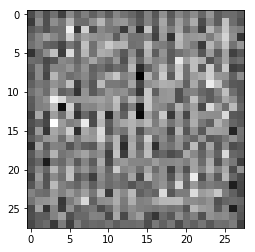

In [13]:
fake_img = generator(latent, condition)
fake_img[0].shape
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [14]:
def get_disc_loss(fake_output, real_output):
    real = cross_entrophy(tf.ones_like(real_output), real_output)
    fake = cross_entrophy(tf.zeros_like(fake_output), fake_output)
    return real + fake

def get_gen_loss(fake_output):
    return cross_entrophy(tf.ones_like(fake_output), fake_output)

In [18]:
for epoch in range(epochs):
    for data in train_dataset:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            real_img, label = data
            latent = tf.random.normal([32, 100])
            fake_img = generator(latent, label)

            real_output = discriminator(real_img, label)
            fake_output = discriminator(fake_img, label)
            d_loss = get_disc_loss(fake_output, real_output)
            g_loss = get_gen_loss(fake_output)

            g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
            d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

            print(f"g_loss : {g_loss} d_loss : {d_loss}")

g_loss : 0.46979817748069763 d_loss : 1.3146380186080933
g_loss : 0.47053956985473633 d_loss : 1.3128207921981812
g_loss : 0.4711715579032898 d_loss : 1.3102281093597412
g_loss : 0.4715721011161804 d_loss : 1.3079032897949219
g_loss : 0.4727080166339874 d_loss : 1.3044523000717163
g_loss : 0.47283148765563965 d_loss : 1.3039311170578003
g_loss : 0.4734465777873993 d_loss : 1.3015103340148926
g_loss : 0.47297531366348267 d_loss : 1.3034213781356812
g_loss : 0.47388654947280884 d_loss : 1.2999005317687988
g_loss : 0.4735923409461975 d_loss : 1.3009793758392334
g_loss : 0.47344884276390076 d_loss : 1.3010070323944092
g_loss : 0.47318437695503235 d_loss : 1.3013968467712402
g_loss : 0.4732598662376404 d_loss : 1.3007535934448242
g_loss : 0.473976194858551 d_loss : 1.300360918045044
g_loss : 0.47339510917663574 d_loss : 1.3003640174865723
g_loss : 0.4738727807998657 d_loss : 1.3006277084350586
g_loss : 0.4745772182941437 d_loss : 1.2988840341567993
g_loss : 0.4744669795036316 d_loss : 1.299

KeyboardInterrupt: 